<a href="https://colab.research.google.com/github/ngtaylor/EE460J-Final-Project/blob/main/EE460J_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis using BERT


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('data/training.1600000.processed.noemoticon.csv.zip', encoding='latin-1', names=["target", "id", "date", "flag", "user", "text"])

In [3]:
#Change positive target value from 4 to 1 and drop flag column since it is useless
df["target"] = df["target"].replace({4:1})
df = df.drop('flag', axis=1)
df.head()

,target,id,date,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
#Shuffle values since they were ordered by target value
df = df.sample(frac = 1)
df.head()

,target,id,date,user,text
425867,0,2063414742,Sun Jun 07 02:33:48 PDT 2009,vipviolet,@elPauloloco hiii I was workingg
1031711,1,1933097538,Tue May 26 22:59:36 PDT 2009,Paqmane,You knew just what to say tonight ..
840003,1,1559611200,Sun Apr 19 11:35:38 PDT 2009,ohsnapspanky,making brownies
1360966,1,2048924625,Fri Jun 05 16:00:11 PDT 2009,jfraziertn,@shelbilavender never too late. But sometim...
1081224,1,1968431780,Fri May 29 21:25:29 PDT 2009,juicyjesso,@hellaMiles HAHAH I love that movie. Have a go...


In [5]:
df['date'] = pd.to_datetime(df['date'], format='%a %b %d %H:%M:%S PDT %Y')

In [6]:
df.dtypes

target             int64
id                 int64
date      datetime64[ns]
user              object
text              object
dtype: object

In [7]:
df['time'] =  pd.to_datetime(df['date'], format='%a %b %d %H:%M:%S PDT %Y').dt.strftime('%H:%M:%S')
df['weekday'] = pd.to_datetime(df['date'], format='%a %b %d %H:%M:%S PDT %Y').dt.weekday
df['day'] = pd.to_datetime(df['date'], format='%a %b %d %H:%M:%S PDT %Y').dt.day
df['month'] = pd.to_datetime(df['date'], format='%a %b %d %H:%M:%S PDT %Y').dt.month
df['year'] = pd.to_datetime(df['date'], format='%a %b %d %H:%M:%S PDT %Y').dt.year

In [8]:
df.head()

,target,id,date,user,text,time,weekday,day,month,year
425867,0,2063414742,2009-06-07 02:33:48,vipviolet,@elPauloloco hiii I was workingg,02:33:48,6,7,6,2009
1031711,1,1933097538,2009-05-26 22:59:36,Paqmane,You knew just what to say tonight ..,22:59:36,1,26,5,2009
840003,1,1559611200,2009-04-19 11:35:38,ohsnapspanky,making brownies,11:35:38,6,19,4,2009
1360966,1,2048924625,2009-06-05 16:00:11,jfraziertn,@shelbilavender never too late. But sometim...,16:00:11,4,5,6,2009
1081224,1,1968431780,2009-05-29 21:25:29,juicyjesso,@hellaMiles HAHAH I love that movie. Have a go...,21:25:29,4,29,5,2009


In [9]:
df.dtypes

target              int64
id                  int64
date       datetime64[ns]
user               object
text               object
time               object
weekday             int64
day                 int64
month               int64
year                int64
dtype: object

In [10]:
df['time'].astype(str)

425867     02:33:48
1031711    22:59:36
840003     11:35:38
1360966    16:00:11
1081224    21:25:29
             ...   
878436     23:34:41
408830     17:03:17
782859     01:26:05
1411028    11:03:31
939018     03:16:50
Name: time, Length: 1600000, dtype: object

In [11]:
df_date = df.copy()[['target', 'date']]
df_date['hour'] = pd.to_datetime(df_date['date'], format='%a %b %d %H:%M:%S PDT %Y').dt.hour
df_date['doy'] = pd.to_datetime(df_date['date'], format='%a %b %d %H:%M:%S PDT %Y').dt.dayofyear
df_date['month'] = pd.to_datetime(df_date['date'], format='%a %b %d %H:%M:%S PDT %Y').dt.month
df_date['dow'] = pd.to_datetime(df_date['date'], format='%a %b %d %H:%M:%S PDT %Y').dt.dayofweek

df_date.head()

,target,date,hour,doy,month,dow
425867,0,2009-06-07 02:33:48,2,158,6,6
1031711,1,2009-05-26 22:59:36,22,146,5,1
840003,1,2009-04-19 11:35:38,11,109,4,6
1360966,1,2009-06-05 16:00:11,16,156,6,4
1081224,1,2009-05-29 21:25:29,21,149,5,4


In [12]:
temporal_hour = pd.pivot_table(df_date, index='target', columns='hour', aggfunc='size', fill_value=0)

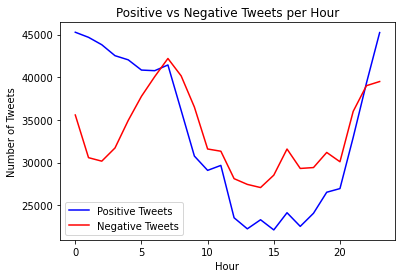

In [13]:
labels = df_date.hour.drop_duplicates()
labels = labels.sort_values()
plt.plot(labels, temporal_hour.transpose()[1], color = 'blue', label = 'Positive Tweets')
plt.plot(labels, temporal_hour.transpose()[0], color = 'red', label = 'Negative Tweets')
plt.xlabel('Hour')
plt.ylabel('Number of Tweets')
plt.title('Positive vs Negative Tweets per Hour')
plt.legend()
plt.show()

In [14]:
temporal_day = pd.pivot_table(df_date, index='target', columns='doy', aggfunc='size', fill_value=0)

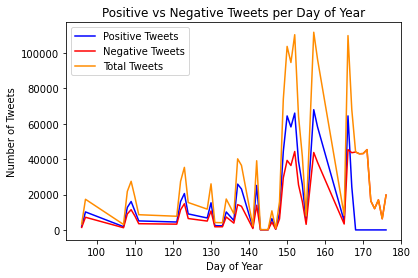

In [15]:
labels = df_date.doy.drop_duplicates()
labels = labels.sort_values()
plt.plot(labels, temporal_day.transpose()[1], color = 'blue', label = 'Positive Tweets')
plt.plot(labels, temporal_day.transpose()[0], color = 'red', label = 'Negative Tweets')
plt.plot(labels, temporal_day.transpose()[1] + temporal_day.transpose()[0], color = 'darkorange', label = 'Total Tweets')
plt.xlabel('Day of Year')
plt.ylabel('Number of Tweets')
plt.title('Positive vs Negative Tweets per Day of Year')
plt.legend()
plt.show()

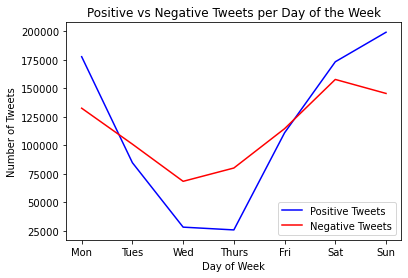

In [16]:
temporal_day = pd.pivot_table(df_date, index='target', columns='dow', aggfunc='size', fill_value=0)
labels = ["Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun"]
plt.plot(labels, temporal_day.transpose()[1], color = 'blue', label = 'Positive Tweets')
plt.plot(labels, temporal_day.transpose()[0], color = 'red', label = 'Negative Tweets')
plt.xlabel('Day of Week')
plt.ylabel('Number of Tweets')
plt.title('Positive vs Negative Tweets per Day of the Week')
plt.legend()
plt.show()

In [17]:
df_text = df.copy()[['target', 'text']]

In [18]:
df_text['len'] = df['text'].apply(len)
df_text.head()

,target,text,len
425867,0,@elPauloloco hiii I was workingg,33
1031711,1,You knew just what to say tonight ..,37
840003,1,making brownies,16
1360966,1,@shelbilavender never too late. But sometim...,95
1081224,1,@hellaMiles HAHAH I love that movie. Have a go...,86


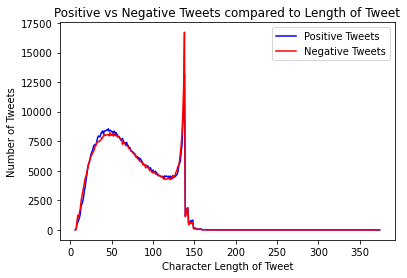

In [19]:
labels = df_text.len.drop_duplicates()
labels = labels.sort_values()
temporal_len = pd.pivot_table(df_text, index='target', columns='len', aggfunc='size', fill_value=0)
plt.plot(labels, temporal_len.transpose()[1], color = 'blue', label = 'Positive Tweets')
plt.plot(labels, temporal_len.transpose()[0], color = 'red', label = 'Negative Tweets')
plt.xlabel('Character Length of Tweet')
plt.ylabel('Number of Tweets')
plt.title('Positive vs Negative Tweets compared to Length of Tweet')
plt.legend()
plt.show()